# Imports

In [39]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [40]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [41]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [42]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


136245
Int64Index([118664], dtype='int64')
136244


In [43]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

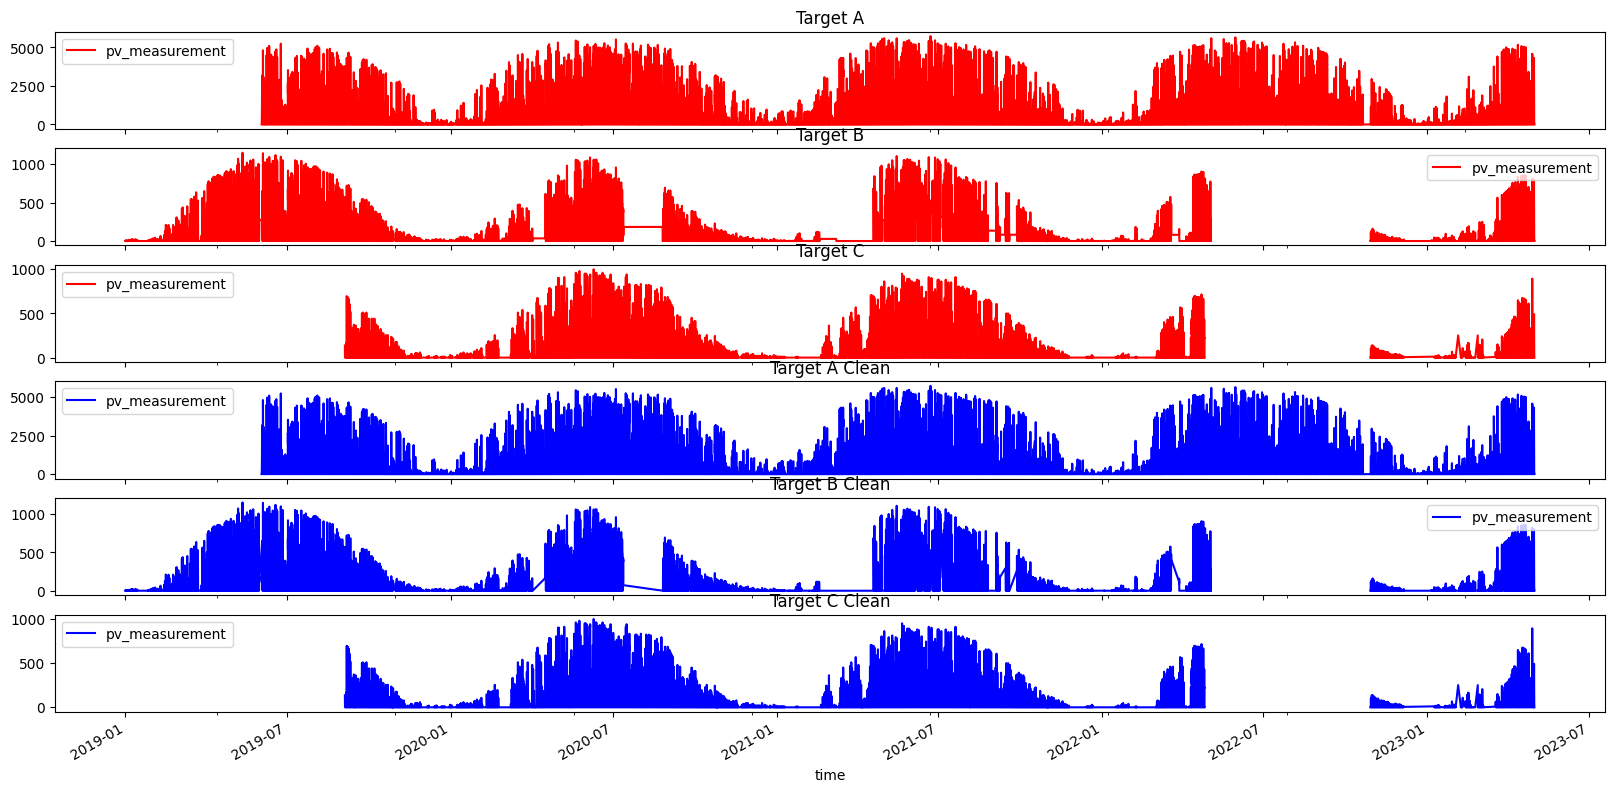

In [44]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



In [45]:
# def shift_all_h_columns(df: pd.DataFrame):
#     # print length of df before and after
#     print("before" + str(len(df)))
#     # This functions shifts the given columns by 1.
#     columns_to_shift = ['diffuse_rad_1h:J', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'fresh_snow_1h:cm']
#     for column in columns_to_shift:
#         df[column] = df[column].shift(-4)
    
#     print("After" + str(len(df)))
#     return df
    

In [46]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [47]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


# Feature engineering

In [48]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


In [49]:
## Multiplying effective cloud coverage with clear sky radiation
# from data_func.feature_engineering.combine import multiply_columns

# def flip_percent(x):
#     return (x-100)*-1

# for i in range(len(X_train)):
#     A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
#     B = X_train[i]['clear_sky_energy_1h:J']
#     AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
#     BT = X_frames_test[i]['clear_sky_energy_1h:J']

#     X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
#     X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)


# Datacleaning

In [50]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199
snow_density:kgm3,32920,28040,24561


In [51]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [52]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)




In [53]:

print(X_train[0]['estimated'])


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34055    1.0
34056    1.0
34057    1.0
34058    1.0
34059    1.0
Name: estimated, Length: 34060, dtype: float64


In [54]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)

# drop_estimated = ['estimated', 'estimation_calc_forecast_difference']
# for i in range(len(X_train)):
#     X_train[i].drop(columns=drop_estimated, inplace=True)
#     X_frames_test[i].drop(columns=drop_estimated, inplace=True)

# X_train[0].head(10)


,count,mean,std,min,25%,50%,75%,max
is_day:idx,34060.0,0.486524,0.499826,0.0,0.0,0.0,1.0,1.0
is_in_shadow:idx,34060.0,0.526395,0.49931,0.0,0.0,1.0,1.0,1.0
absolute_humidity_2m:gm3,34060.0,6.32236,2.799474,0.7,4.2,5.8,8.25,17.35
air_density_2m:kgm3,34060.0,1.253279,0.037206,1.145,1.2275,1.2515,1.27725,1.42625
ceiling_height_agl:m,34060.0,6036.402832,6939.430176,27.849998,1286.950012,2651.512451,7567.643433,20000.0
...,...,...,...,...,...,...,...,...
precip_type_5min:idx_5,34060.0,0.000029,0.005418,0.0,0.0,0.0,0.0,1.0
msl_pressure:hPa_mean,34060.0,1004.529297,12.679372,939.75,996.625,1005.46875,1013.3125,1038.943726
diffuse_rad:W_mean,34060.0,47.350224,79.670685,0.0,0.0,1.075,63.8,386.637512
diffuse_rad_1h:J_mean,34060.0,170460.8125,283951.21875,0.0,0.0,9506.400391,229745.234375,1382627.125


# Hyperparameter optimization

### Xgboost

In [55]:
# import optuna
# import xgboost as xgb # Change to model to optimize

# # Split the data into training and validation sets
# x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_frames_train[0], Y_frames_train[0], test_size=0.17, random_state=None)
# x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_frames_train[1], Y_frames_train[1], test_size=0.17, random_state=None)
# x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_frames_train[2], Y_frames_train[2], test_size=0.17, random_state=None)


# def objective(trial):
    
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.01, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
#         'random_state': 42,
#     }

#     model = xgb.XGBRegressor(**params) # Change to model to optimize
#     model.fit(x_train_c, y_train_c)

#     # Make predictions on the validation set
#     y_pred = model.predict(x_val_c)

#     # Calculate the Mean Squared Error (MSE) as the metric to optimize
#     mae = mean_absolute_error(y_val_c, y_pred)

#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# best = study.best_params
# # Print the best hyperparameters found
# print("Best hyperparameters:", best)



### Catboost

In [56]:
# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)


In [57]:
import optuna
import catboost as cat # Change to model to optimize
# Split the data into training and validation sets



categorical_column = ['dew_or_rime:idx_-1',	'dew_or_rime:idx_0','dew_or_rime:idx_1', 'precip_type_5min:idx_0','precip_type_5min:idx_1','precip_type_5min:idx_2','precip_type_5min:idx_3','precip_type_5min:idx_5', 'is_day:idx', 'is_in_shadow:idx']

def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "cat_features": categorical_column,
        "random_seed": 42,
        "loss_function": "MAE",
        "eval_metric": "MAE",
    }

    model = cat.CatBoostRegressor(**params) # Change to model to optimize
    model.fit(x_train_a, y_train_a)

    # Make predictions on the validation set
    y_pred = model.predict(x_val_a)

    # Calculate the Mean Squared Error (MSE) as the metric to optimize
    mae = mean_absolute_error(y_val_a, y_pred)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best = study.best_params
# Print the best hyperparameters foundc
print("Best hyperparameters:", best)


[I 2023-11-10 10:30:39,893] A new study created in memory with name: no-name-a1fb1394-5e9d-4f5b-af06-5d96728a8b50


0:	learn: 631.2821019	total: 2.81ms	remaining: 2.81s
1:	learn: 627.2477306	total: 5.53ms	remaining: 2.76s
2:	learn: 623.5145674	total: 7.81ms	remaining: 2.59s
3:	learn: 620.4747110	total: 10.2ms	remaining: 2.54s
4:	learn: 616.6607236	total: 12.6ms	remaining: 2.5s
5:	learn: 613.6701636	total: 14.9ms	remaining: 2.47s
6:	learn: 610.8694162	total: 17.4ms	remaining: 2.47s
7:	learn: 608.2555224	total: 20ms	remaining: 2.48s
8:	learn: 604.7530470	total: 22.4ms	remaining: 2.46s
9:	learn: 601.8766114	total: 24.7ms	remaining: 2.45s
10:	learn: 599.3392240	total: 27.1ms	remaining: 2.44s
11:	learn: 596.0938082	total: 29.4ms	remaining: 2.42s
12:	learn: 593.3090315	total: 32.1ms	remaining: 2.44s
13:	learn: 589.6017585	total: 34.6ms	remaining: 2.44s
14:	learn: 586.5677522	total: 37ms	remaining: 2.43s
15:	learn: 583.7148489	total: 39.2ms	remaining: 2.41s
16:	learn: 579.9418900	total: 41.5ms	remaining: 2.4s
17:	learn: 577.2222248	total: 43.8ms	remaining: 2.39s
18:	learn: 574.5307332	total: 46.1ms	remaini

[I 2023-11-10 10:30:41,536] Trial 0 finished with value: 207.04302374664996 and parameters: {'learning_rate': 0.009000695177236184, 'depth': 3, 'subsample': 0.07389597510083926, 'colsample_bylevel': 0.10633241031698093, 'min_data_in_leaf': 46}. Best is trial 0 with value: 207.04302374664996.


908:	learn: 219.2743220	total: 1.4s	remaining: 140ms
909:	learn: 219.2740681	total: 1.4s	remaining: 138ms
910:	learn: 219.2143254	total: 1.4s	remaining: 137ms
911:	learn: 219.1693335	total: 1.4s	remaining: 135ms
912:	learn: 219.1693090	total: 1.4s	remaining: 134ms
913:	learn: 219.1691807	total: 1.4s	remaining: 132ms
914:	learn: 219.1637393	total: 1.41s	remaining: 131ms
915:	learn: 219.1243008	total: 1.41s	remaining: 129ms
916:	learn: 219.0453455	total: 1.41s	remaining: 128ms
917:	learn: 219.0028890	total: 1.41s	remaining: 126ms
918:	learn: 218.9655959	total: 1.41s	remaining: 124ms
919:	learn: 218.9655849	total: 1.41s	remaining: 123ms
920:	learn: 218.9655823	total: 1.41s	remaining: 121ms
921:	learn: 218.9652975	total: 1.42s	remaining: 120ms
922:	learn: 218.8868516	total: 1.42s	remaining: 118ms
923:	learn: 218.8868172	total: 1.42s	remaining: 117ms
924:	learn: 218.8766854	total: 1.42s	remaining: 115ms
925:	learn: 218.8016293	total: 1.42s	remaining: 114ms
926:	learn: 218.7502554	total: 1.4

[I 2023-11-10 10:30:44,053] Trial 1 finished with value: 175.25138179928229 and parameters: {'learning_rate': 0.05356818604847221, 'depth': 5, 'subsample': 0.42422914657547334, 'colsample_bylevel': 0.23229342226537764, 'min_data_in_leaf': 65}. Best is trial 1 with value: 175.25138179928229.


991:	learn: 174.3395364	total: 2.4s	remaining: 19.4ms
992:	learn: 174.3394325	total: 2.4s	remaining: 16.9ms
993:	learn: 174.3394306	total: 2.4s	remaining: 14.5ms
994:	learn: 174.3381059	total: 2.41s	remaining: 12.1ms
995:	learn: 174.3367402	total: 2.41s	remaining: 9.68ms
996:	learn: 174.3345816	total: 2.41s	remaining: 7.26ms
997:	learn: 174.3344828	total: 2.41s	remaining: 4.84ms
998:	learn: 174.3255481	total: 2.42s	remaining: 2.42ms
999:	learn: 174.3231480	total: 2.42s	remaining: 0us
0:	learn: 630.4647170	total: 15.9ms	remaining: 15.9s
1:	learn: 626.6423735	total: 30ms	remaining: 15s
2:	learn: 622.1504855	total: 43.8ms	remaining: 14.5s
3:	learn: 617.8451313	total: 55.3ms	remaining: 13.8s
4:	learn: 613.1715164	total: 68.8ms	remaining: 13.7s
5:	learn: 608.7338009	total: 81.8ms	remaining: 13.6s
6:	learn: 604.2618550	total: 95.2ms	remaining: 13.5s
7:	learn: 600.1014935	total: 107ms	remaining: 13.3s
8:	learn: 596.1353996	total: 120ms	remaining: 13.2s
9:	learn: 591.4312834	total: 133ms	remai

[I 2023-11-10 10:30:56,775] Trial 2 finished with value: 176.07083339048594 and parameters: {'learning_rate': 0.00902249214012868, 'depth': 10, 'subsample': 0.2355292478731574, 'colsample_bylevel': 0.6460775397031099, 'min_data_in_leaf': 60}. Best is trial 1 with value: 175.25138179928229.


987:	learn: 176.5509351	total: 12.4s	remaining: 150ms
988:	learn: 176.5241135	total: 12.4s	remaining: 138ms
989:	learn: 176.5217848	total: 12.4s	remaining: 125ms
990:	learn: 176.5212953	total: 12.4s	remaining: 113ms
991:	learn: 176.4926619	total: 12.4s	remaining: 100ms
992:	learn: 176.4119522	total: 12.5s	remaining: 87.8ms
993:	learn: 176.3888874	total: 12.5s	remaining: 75.2ms
994:	learn: 176.3731232	total: 12.5s	remaining: 62.7ms
995:	learn: 176.3718434	total: 12.5s	remaining: 50.2ms
996:	learn: 176.3685240	total: 12.5s	remaining: 37.6ms
997:	learn: 176.3495315	total: 12.5s	remaining: 25.1ms
998:	learn: 176.3370502	total: 12.5s	remaining: 12.5ms
999:	learn: 176.2997820	total: 12.5s	remaining: 0us
0:	learn: 622.9372709	total: 18.9ms	remaining: 18.9s
1:	learn: 611.4963002	total: 33.9ms	remaining: 16.9s
2:	learn: 599.7339937	total: 44.8ms	remaining: 14.9s
3:	learn: 587.2362034	total: 52ms	remaining: 13s
4:	learn: 578.1363632	total: 59.1ms	remaining: 11.8s
5:	learn: 568.6271378	total: 65.

[I 2023-11-10 10:31:02,552] Trial 3 finished with value: 170.61985713453515 and parameters: {'learning_rate': 0.024989833429664883, 'depth': 7, 'subsample': 0.5966151522474651, 'colsample_bylevel': 0.7369968377467557, 'min_data_in_leaf': 100}. Best is trial 3 with value: 170.61985713453515.


0:	learn: 611.6368482	total: 6.67ms	remaining: 6.67s
1:	learn: 589.3851528	total: 12.4ms	remaining: 6.2s
2:	learn: 568.3915004	total: 18.6ms	remaining: 6.18s
3:	learn: 546.6106892	total: 25.4ms	remaining: 6.33s
4:	learn: 526.1222610	total: 28.7ms	remaining: 5.71s
5:	learn: 507.1074840	total: 34.4ms	remaining: 5.7s
6:	learn: 489.6555816	total: 40.1ms	remaining: 5.69s
7:	learn: 470.6090847	total: 45.5ms	remaining: 5.65s
8:	learn: 454.3180219	total: 50.8ms	remaining: 5.6s
9:	learn: 438.0316842	total: 55.7ms	remaining: 5.52s
10:	learn: 424.2658837	total: 60.5ms	remaining: 5.44s
11:	learn: 411.0252636	total: 66.2ms	remaining: 5.45s
12:	learn: 400.3868600	total: 72.2ms	remaining: 5.48s
13:	learn: 388.8018945	total: 77.6ms	remaining: 5.47s
14:	learn: 376.8699059	total: 82.7ms	remaining: 5.43s
15:	learn: 366.3668885	total: 88.2ms	remaining: 5.42s
16:	learn: 355.0728645	total: 92.9ms	remaining: 5.37s
17:	learn: 345.5003433	total: 97.8ms	remaining: 5.33s
18:	learn: 335.9613347	total: 103ms	remai

[I 2023-11-10 10:31:07,506] Trial 4 finished with value: 155.794849241746 and parameters: {'learning_rate': 0.04918121073433389, 'depth': 10, 'subsample': 0.11550677449235054, 'colsample_bylevel': 0.09854675972090227, 'min_data_in_leaf': 88}. Best is trial 4 with value: 155.794849241746.


0:	learn: 634.0695722	total: 7.88ms	remaining: 7.87s
1:	learn: 633.6218214	total: 14.3ms	remaining: 7.14s
2:	learn: 633.1737948	total: 21.8ms	remaining: 7.24s
3:	learn: 632.7086711	total: 29.2ms	remaining: 7.28s
4:	learn: 632.2652358	total: 36.4ms	remaining: 7.24s
5:	learn: 631.8504614	total: 42.6ms	remaining: 7.06s
6:	learn: 631.4620724	total: 48.9ms	remaining: 6.94s
7:	learn: 630.9829324	total: 55.9ms	remaining: 6.92s
8:	learn: 630.4524132	total: 62.7ms	remaining: 6.91s
9:	learn: 629.8567566	total: 69.2ms	remaining: 6.85s
10:	learn: 629.3844309	total: 75ms	remaining: 6.75s
11:	learn: 628.9326424	total: 82.4ms	remaining: 6.79s
12:	learn: 628.4635857	total: 88.4ms	remaining: 6.71s
13:	learn: 627.9726656	total: 94.4ms	remaining: 6.64s
14:	learn: 627.4976689	total: 101ms	remaining: 6.65s
15:	learn: 627.0189236	total: 108ms	remaining: 6.64s
16:	learn: 626.6097968	total: 114ms	remaining: 6.59s
17:	learn: 626.1256853	total: 121ms	remaining: 6.59s
18:	learn: 625.5717220	total: 127ms	remainin

[I 2023-11-10 10:31:14,027] Trial 5 finished with value: 306.3646455795709 and parameters: {'learning_rate': 0.001053854579534835, 'depth': 8, 'subsample': 0.7778075488701074, 'colsample_bylevel': 0.2664130479673271, 'min_data_in_leaf': 72}. Best is trial 4 with value: 155.794849241746.


982:	learn: 322.1829407	total: 6.29s	remaining: 109ms
983:	learn: 322.0124976	total: 6.29s	remaining: 102ms
984:	learn: 321.8516233	total: 6.3s	remaining: 95.9ms
985:	learn: 321.6909605	total: 6.31s	remaining: 89.5ms
986:	learn: 321.5251810	total: 6.31s	remaining: 83.1ms
987:	learn: 321.3564542	total: 6.32s	remaining: 76.7ms
988:	learn: 321.1891334	total: 6.32s	remaining: 70.3ms
989:	learn: 321.0268006	total: 6.33s	remaining: 63.9ms
990:	learn: 320.8687769	total: 6.34s	remaining: 57.6ms
991:	learn: 320.7408162	total: 6.34s	remaining: 51.2ms
992:	learn: 320.5863624	total: 6.35s	remaining: 44.8ms
993:	learn: 320.4273045	total: 6.36s	remaining: 38.4ms
994:	learn: 320.2761933	total: 6.36s	remaining: 32ms
995:	learn: 320.1124314	total: 6.37s	remaining: 25.6ms
996:	learn: 319.9579382	total: 6.37s	remaining: 19.2ms
997:	learn: 319.7838901	total: 6.38s	remaining: 12.8ms
998:	learn: 319.6118830	total: 6.38s	remaining: 6.39ms
999:	learn: 319.4812626	total: 6.39s	remaining: 0us
0:	learn: 612.0020

[I 2023-11-10 10:31:18,564] Trial 6 finished with value: 169.0965196227392 and parameters: {'learning_rate': 0.053393588789109776, 'depth': 6, 'subsample': 0.9531859186216574, 'colsample_bylevel': 0.8498059208913513, 'min_data_in_leaf': 57}. Best is trial 4 with value: 155.794849241746.


956:	learn: 165.7532989	total: 4.25s	remaining: 191ms
957:	learn: 165.7485579	total: 4.25s	remaining: 186ms
958:	learn: 165.7485070	total: 4.25s	remaining: 182ms
959:	learn: 165.7375965	total: 4.26s	remaining: 177ms
960:	learn: 165.7168432	total: 4.26s	remaining: 173ms
961:	learn: 165.7147319	total: 4.27s	remaining: 169ms
962:	learn: 165.7145322	total: 4.27s	remaining: 164ms
963:	learn: 165.7138720	total: 4.27s	remaining: 160ms
964:	learn: 165.7048397	total: 4.28s	remaining: 155ms
965:	learn: 165.6051330	total: 4.28s	remaining: 151ms
966:	learn: 165.6035978	total: 4.29s	remaining: 146ms
967:	learn: 165.6035046	total: 4.29s	remaining: 142ms
968:	learn: 165.5989625	total: 4.3s	remaining: 137ms
969:	learn: 165.5951403	total: 4.3s	remaining: 133ms
970:	learn: 165.5949815	total: 4.3s	remaining: 129ms
971:	learn: 165.5604606	total: 4.31s	remaining: 124ms
972:	learn: 165.5495101	total: 4.31s	remaining: 120ms
973:	learn: 165.4850142	total: 4.32s	remaining: 115ms
974:	learn: 165.4719471	total: 

[I 2023-11-10 10:31:20,577] Trial 7 finished with value: 216.65071407552813 and parameters: {'learning_rate': 0.027912131103109777, 'depth': 1, 'subsample': 0.21464509513179622, 'colsample_bylevel': 0.5135246144593255, 'min_data_in_leaf': 11}. Best is trial 4 with value: 155.794849241746.


915:	learn: 228.6905111	total: 1.79s	remaining: 165ms
916:	learn: 228.6904977	total: 1.79s	remaining: 162ms
917:	learn: 228.6904977	total: 1.8s	remaining: 160ms
918:	learn: 228.6904977	total: 1.8s	remaining: 158ms
919:	learn: 228.6904977	total: 1.8s	remaining: 157ms
920:	learn: 228.6904977	total: 1.8s	remaining: 155ms
921:	learn: 228.6904977	total: 1.8s	remaining: 153ms
922:	learn: 228.6904977	total: 1.8s	remaining: 151ms
923:	learn: 228.6899151	total: 1.8s	remaining: 149ms
924:	learn: 228.6899151	total: 1.81s	remaining: 147ms
925:	learn: 228.6899015	total: 1.81s	remaining: 145ms
926:	learn: 228.6899015	total: 1.81s	remaining: 143ms
927:	learn: 228.6898882	total: 1.81s	remaining: 141ms
928:	learn: 228.6898882	total: 1.81s	remaining: 139ms
929:	learn: 228.6893419	total: 1.81s	remaining: 137ms
930:	learn: 228.6893419	total: 1.82s	remaining: 135ms
931:	learn: 228.6893419	total: 1.82s	remaining: 133ms
932:	learn: 228.6893419	total: 1.82s	remaining: 131ms
933:	learn: 228.6893419	total: 1.82

[I 2023-11-10 10:31:23,018] Trial 8 finished with value: 185.23983419086213 and parameters: {'learning_rate': 0.03360664574231246, 'depth': 4, 'subsample': 0.10786370821214653, 'colsample_bylevel': 0.8801903001626071, 'min_data_in_leaf': 27}. Best is trial 4 with value: 155.794849241746.


934:	learn: 192.1913837	total: 2.21s	remaining: 154ms
935:	learn: 192.1913770	total: 2.21s	remaining: 151ms
936:	learn: 192.1913758	total: 2.21s	remaining: 149ms
937:	learn: 192.1908099	total: 2.22s	remaining: 147ms
938:	learn: 192.1402416	total: 2.22s	remaining: 144ms
939:	learn: 192.1194257	total: 2.22s	remaining: 142ms
940:	learn: 192.1147700	total: 2.22s	remaining: 139ms
941:	learn: 192.1146189	total: 2.23s	remaining: 137ms
942:	learn: 192.0988675	total: 2.23s	remaining: 135ms
943:	learn: 192.0872652	total: 2.23s	remaining: 132ms
944:	learn: 192.0871037	total: 2.23s	remaining: 130ms
945:	learn: 192.0870712	total: 2.23s	remaining: 128ms
946:	learn: 192.0741641	total: 2.24s	remaining: 125ms
947:	learn: 192.0741641	total: 2.24s	remaining: 123ms
948:	learn: 192.0740201	total: 2.24s	remaining: 120ms
949:	learn: 192.0679962	total: 2.24s	remaining: 118ms
950:	learn: 192.0679960	total: 2.24s	remaining: 116ms
951:	learn: 192.0284536	total: 2.25s	remaining: 113ms
952:	learn: 192.0249130	tota

[I 2023-11-10 10:31:34,667] Trial 9 finished with value: 214.7055340414611 and parameters: {'learning_rate': 0.0021058932304135534, 'depth': 10, 'subsample': 0.9320365251206896, 'colsample_bylevel': 0.4231053085349948, 'min_data_in_leaf': 67}. Best is trial 4 with value: 155.794849241746.


Best hyperparameters: {'learning_rate': 0.04918121073433389, 'depth': 10, 'subsample': 0.11550677449235054, 'colsample_bylevel': 0.09854675972090227, 'min_data_in_leaf': 88}
